## Initial Data



In [140]:
import pyspark
from pyspark.sql import SparkSession
from IPython.display import display, HTML

spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkByExamples.com') \
                    .getOrCreate()

df = spark.read.option("header",True).csv('/Users/liliana.manjarres/Documents/Sr_DE_Takehome/dataset.csv')
df.createOrReplaceTempView("events_tmp")
df2 = spark.sql("select *, to_date(timestamp) as date from events_tmp")
df2.createOrReplaceTempView("events")
df2.show()

+--------------------+--------------------+------------------+--------+-----------+----------+
|           timestamp|             user_id|             event|flyer_id|merchant_id|      date|
+--------------------+--------------------+------------------+--------+-----------+----------+
|2018-10-01T13:54:...|9ea672779feb1e088...|shopping_list_open|    null|       null|2018-10-01|
|2018-10-01T13:34:...|01ca5536abc5e0992...|shopping_list_open|    null|       null|2018-10-01|
|2018-10-01T13:56:...|1c1231e7a41a1bee1...|        flyer_open| 2016315|       2268|2018-10-01|
|2018-10-01T13:36:...|b38f97880ccb69e8f...|shopping_list_open|    null|       null|2018-10-01|
|2018-10-01T13:56:...|b38f97880ccb69e8f...|shopping_list_open|    null|       null|2018-10-01|
|2018-10-01T13:36:...|9ea672779feb1e088...|shopping_list_open|    null|       null|2018-10-01|
|2018-10-01T13:34:...|7c3e5dadd6c0d7170...|        flyer_open| 1993325|       2188|2018-10-01|
|2018-10-01T13:31:...|9ea672779feb1e088...|       

## Exploring data



In [51]:
from pyspark.sql.functions import count
from pyspark.sql.functions import countDistinct
df.select(countDistinct(df.user_id)).show()
df.select(countDistinct(df.event)).show()
df.select(countDistinct(df.flyer_id)).show()
df.select(countDistinct(df.merchant_id)).show()
spark.sql("select event, count(1) as total from events group by event").show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                   1190|
+-----------------------+

+---------------------+
|count(DISTINCT event)|
+---------------------+
|                    5|
+---------------------+

+------------------------+
|count(DISTINCT flyer_id)|
+------------------------+
|                    1659|
+------------------------+

+---------------------------+
|count(DISTINCT merchant_id)|
+---------------------------+
|                        523|
+---------------------------+

+------------------+-----+
|             event|total|
+------------------+-----+
|          favorite|  257|
|shopping_list_open| 3100|
|        flyer_open|14956|
|       list_flyers|  855|
|         item_open| 1555|
+------------------+-----+



## Total of open_flyers events by date, merchant



In [153]:
result_df = spark.sql("select date, merchant_id, count(1) as total_flyer_open\
           from events \
           where event == 'flyer_open'\
           group by date, merchant_id \
           order by total_flyer_open desc")
result_df_pd = result_df.toPandas()
display(HTML(result_df_pd.to_html()))

,date,merchant_id,total_flyer_open
0,2018-10-01,246,785
1,2018-10-01,2345,690
2,2018-10-01,2268,639
3,2018-10-01,2609,583
4,2018-10-01,2280,493
5,2018-10-01,2284,416
6,2018-10-01,2163,411
7,2018-10-01,2484,376
8,2018-10-01,2282,371
9,2018-10-01,2366,335


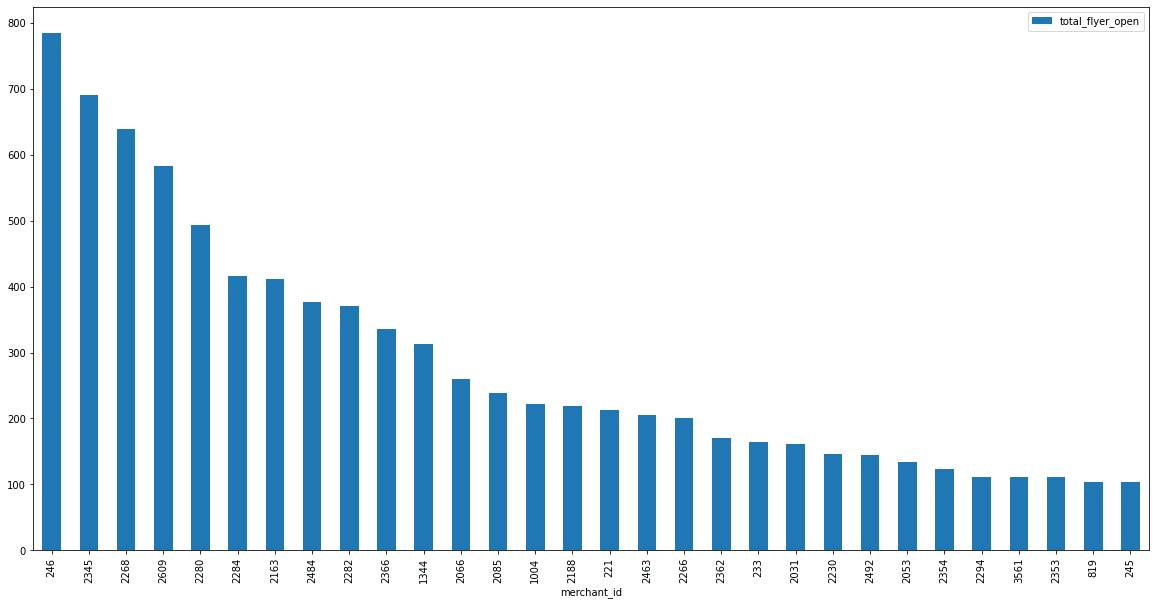

In [154]:
import matplotlib.pyplot as plt
result_df_pd.head(30).plot(x="merchant_id", y=["total_flyer_open"], kind="bar",figsize=(20,10));


In [173]:
#Second option using Generators

import csv

def read_csv_from_generator_fn():
    with open('/Users/liliana.manjarres/Documents/Sr_DE_Takehome/dataset.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            yield row

open_flyers_by_merchant =[]

for row in read_csv_from_generator_fn():
    if row[2]=='flyer_open':
        merchat=row[4]
        filtered = list(filter(lambda item: item['merchant_id'] == merchat, open_flyers_by_merchant))
        if (len(filtered)==0):   
            open_flyers_by_merchant.append({
              "merchant_id": merchat,
              "total": 1
            })
        else:
            total = filtered[0]['total']
            tmp_list = list(filter(lambda item: item['merchant_id'] != merchat, open_flyers_by_merchant))
            tmp_list.append({
              "merchant_id": merchat,
              "total": total + 1
            })
            open_flyers_by_merchant=tmp_list
        
print(open_flyers_by_merchant)
    

[{'merchant_id': '2838', 'total': 1}, {'merchant_id': '4629', 'total': 2}, {'merchant_id': '4456', 'total': 1}, {'merchant_id': '2226', 'total': 1}, {'merchant_id': '3563', 'total': 1}, {'merchant_id': '2391', 'total': 1}, {'merchant_id': '3859', 'total': 1}, {'merchant_id': '3556', 'total': 3}, {'merchant_id': '2666', 'total': 1}, {'merchant_id': '3106', 'total': 1}, {'merchant_id': '4461', 'total': 1}, {'merchant_id': '3006', 'total': 1}, {'merchant_id': '4400', 'total': 1}, {'merchant_id': '3508', 'total': 1}, {'merchant_id': '3624', 'total': 1}, {'merchant_id': '3298', 'total': 2}, {'merchant_id': '1499', 'total': 1}, {'merchant_id': '3288', 'total': 3}, {'merchant_id': '3234', 'total': 1}, {'merchant_id': '2829', 'total': 1}, {'merchant_id': '4295', 'total': 1}, {'merchant_id': '3066', 'total': 1}, {'merchant_id': '4660', 'total': 1}, {'merchant_id': '2820', 'total': 1}, {'merchant_id': '3630', 'total': 1}, {'merchant_id': '5619', 'total': 1}, {'merchant_id': '3421', 'total': 2}, 